In [1]:
import torchvision.transforms as transforms   
from torch.utils.data import DataLoader       

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from tqdm import tqdm
import os
import random

from skimage import io,color
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report

import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

In [2]:
import warnings

warnings.filterwarnings("ignore")

# C0 Data preparation

In [3]:
path = 'UTKFace'
age_labels = []
gender_labels = []
image_paths = []
image_filenames = os.listdir(path)

for image in image_filenames:
    image_path = os.path.join(path, image)
    img_components = image.split('_')
    age_label = int(img_components[0])
    gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
    age_labels.append(age_label)
    gender_labels.append(gender_label)
    image_paths.append(image_path)

print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

gender_mapping = {
    1: 'Female',
    0: 'Male'
}

df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(10)

Number of age_labels: 23708, Number of gender_labels: 23708, Number of image_paths: 23708


,image_path,age,gender
0,UTKFace\100_0_0_20170112213500903.jpg.chip.jpg,100,0
1,UTKFace\100_0_0_20170112215240346.jpg.chip.jpg,100,0
2,UTKFace\100_1_0_20170110183726390.jpg.chip.jpg,100,1
3,UTKFace\100_1_0_20170112213001988.jpg.chip.jpg,100,1
4,UTKFace\100_1_0_20170112213303693.jpg.chip.jpg,100,1
5,UTKFace\100_1_0_20170112215032192.jpg.chip.jpg,100,1
6,UTKFace\100_1_0_20170117195420803.jpg.chip.jpg,100,1
7,UTKFace\100_1_0_20170119212053665.jpg.chip.jpg,100,1
8,UTKFace\100_1_2_20170105174847679.jpg.chip.jpg,100,1
9,UTKFace\100_1_2_20170112213615815.jpg.chip.jpg,100,1


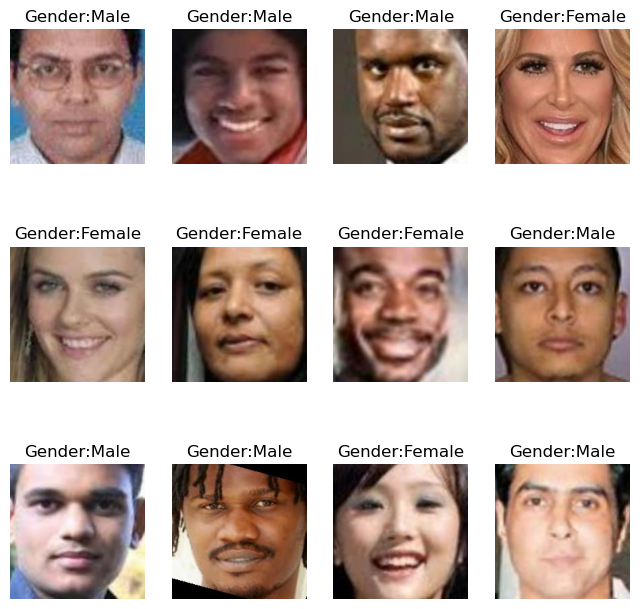

<Figure size 1500x200 with 0 Axes>

<Figure size 1500x200 with 0 Axes>

<Figure size 1500x200 with 0 Axes>

<Figure size 1500x200 with 0 Axes>

<Figure size 1500x200 with 0 Axes>

<Figure size 1500x200 with 0 Axes>

<Figure size 1500x200 with 0 Axes>

<Figure size 1500x200 with 0 Axes>

<Figure size 1500x200 with 0 Axes>

<Figure size 1500x200 with 0 Axes>

<Figure size 1500x200 with 0 Axes>

<Figure size 1500x200 with 0 Axes>

In [4]:
fig, ax = plt.subplots(3, 4, figsize=(8,8))

for i, axi in enumerate(ax.flat):
    a = random.randint(0,20000)
    image_path = df['image_path'][i+a]
    image = io.imread(image_path)
    gender = gender_mapping[df['gender'][i+a]]
    fig = plt.figure(figsize=(15, 2))
    
    axi.imshow(image)
    axi.set(title=f'Gender:{gender}')
    axi.axis('off')
    
    

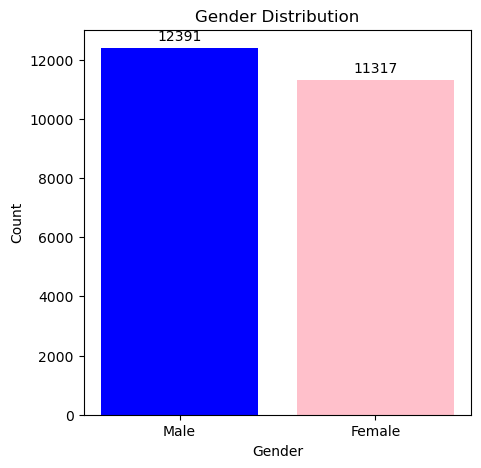

In [4]:
value_counts = df['gender'].value_counts()

gender_data = {
    'Gender': ['Male', 'Female'],
    'Count': [12391, 11317]
}

plt.figure(figsize=(5, 5))

bars = plt.bar(gender_data['Gender'], gender_data['Count'], color=['blue', 'pink'])

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}', 
                 xy=(bar.get_x() + bar.get_width() / 2, height),  
                 xytext=(0, 3),  
                 textcoords='offset points',
                 ha='center', 
                 va='bottom'  
                 )

plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.show()

# C1 

- Using cross-validation to select the better of two models while eliminating overfitting. In this experiment, both CNNs and MLPs exhibited overfitting, and regularization techniques such as Dropout and early stopping were employed to address this issue.

In [5]:
# identfy a custom Dataset class,considering the load of memory
class Dataset(Dataset):
    def __init__(self, data_paths, labels, transform=None):
        self.data_paths = data_paths  
        self.labels = labels  
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        image_path = self.data_paths[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]  
        

        return image, label
    


In [6]:
# split train and val set

X = df.iloc[:,0]
y = df['gender']
X_train,X_val,y_train,y_val = train_test_split(X,y,random_state=42,test_size=0.3)


In [17]:
# Preparetion for Nomalization

image_paths_train = X_train.to_list()
labels_train = y_train.to_list()


dataset = Dataset(image_paths_train,labels_train, transform=transforms.ToTensor())

loader = DataLoader(dataset, batch_size=1, shuffle=False)

mean = 0.0
std = 0.0
for images, _ in tqdm(loader):
    batch_samples = images.size(0)  
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)

print("Mean:", mean)
print("Std:", std)

100%|███████████████████████████████████████████████████████████████████████████| 16595/16595 [01:28<00:00, 188.12it/s]

Mean: tensor([0.5954, 0.4555, 0.3897])
Std: tensor([0.2193, 0.1951, 0.1858])


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5954, 0.4555, 0.3897], std=[0.2193, 0.1951, 0.1858]),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((50,50)),
    
])


In [8]:
# subclass of train set for learning
cv_ind = np.arange(len(X_train))[0:10000].tolist()
cv_X = [X_train.tolist()[a] for a in cv_ind]
cv_y = [y_train.tolist()[a] for a in cv_ind]

# subclass of train set for test
test_ind = np.arange(len(X_train))[10001:].tolist()
test_X = [X_train.tolist()[a] for a in test_ind]
test_y = [y_train.tolist()[a] for a in test_ind]

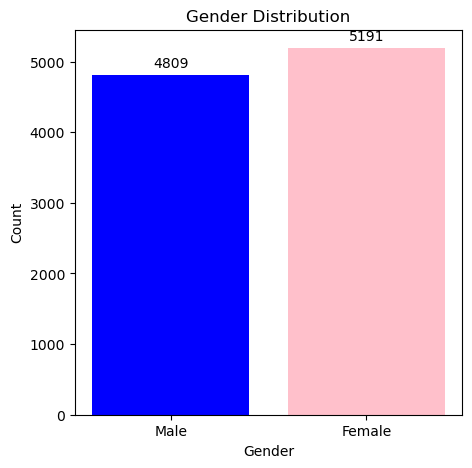

In [9]:

gender_data = {
    'Gender': ['Male', 'Female'],
    'Count': [sum(cv_y), 10000-sum(cv_y)]
}

plt.figure(figsize=(5, 5))

bars = plt.bar(gender_data['Gender'], gender_data['Count'], color=['blue', 'pink'])

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}', 
                 xy=(bar.get_x() + bar.get_width() / 2, height),  
                 xytext=(0, 3),  
                 textcoords='offset points',
                 ha='center', 
                 va='bottom'  
                 )

plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.show()

In [10]:
def generateDataloader(X,y,transform):
    if type(X) is not list:
        image_paths = X.to_list()
        labels = y.to_list()
    else:
        image_paths = X
        labels = y
    
    dataset = Dataset(image_paths, labels, transform=transform)
    del image_paths,labels
    return dataset

## C1.1 Model1:CNNs

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

In [39]:
class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()  
        
        # (batch_size,1,50,50)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3) 
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3) 
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(3872, 200)  
        self.fc2 = nn.Linear(200, 2)  
        self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, self.flat_features(x)) 
        x = F.relu(self.fc1(x)) 
        x = self.dropout(x)
        x = self.fc2(x)         
        return x
    
    def flat_features(self, x): 
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
class CNN_wr(nn.Module): 
    def __init__(self):
        super(CNN_wr, self).__init__()  
        
        # (batch_size,1,50,50)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3) 
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3) 
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(3872, 200)  
        self.fc2 = nn.Linear(200, 2)  
        #self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, self.flat_features(x)) 
        x = F.relu(self.fc1(x)) 
        #x = self.dropout(x)
        x = self.fc2(x)         
        return x
    
    def flat_features(self, x): 
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [13]:
def trainCNN(X_train,y_train,X_test,y_test,batchsize=100,lr=0.001,epoch=20, transform=transform):
    # generate dataloader
    dataset_train = generateDataloader(X_train,y_train,transform=transform)
    dataloader_train = DataLoader(dataset_train, batch_size= batchsize, shuffle=True)
    dataset_test = generateDataloader(X_test,y_test,transform=transform)
    dataloader_test = DataLoader(dataset_test, batch_size= batchsize, shuffle=False)
    # initialize model    
    net = CNN() 
    device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    
    criterion = nn.CrossEntropyLoss()   
    optimizer = optim.Adam(net.parameters(), lr = lr) 
    criterion = criterion.to(device)
    
    best_validation_loss = float('inf')
    no_improvement_count = 0
    torrance = 2 
    for epoch in range(epoch):
        training_loss = []
        test_loss = []
        net.train()
        for batch_X,batch_y in dataloader_train:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()        
            pred_y = net(batch_X)    
            loss = criterion(pred_y, batch_y)      
            loss.backward()
            optimizer.step() 
            training_loss.append(loss.item())
    
        
        net.eval()
        with torch.no_grad():
            for batch_X, batch_y in dataloader_test:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device) 
                outputs = net(batch_X)
                loss_eval = criterion(outputs, batch_y) 
                test_loss.append(loss_eval.item())
        
        test_current_loss = np.mean(test_loss)
        
        if test_current_loss < best_validation_loss:
            best_validation_loss = test_current_loss
            no_improvement_count = 0
            # torch.save(model.state_dict(), 'best_model.pth')
        else:
            no_improvement_count += 1
            
        if  no_improvement_count>= torrance:   
            print(f"Early stopping after {epoch} epochs.")
            break

    del loss
    del pred_y
    torch.cuda.empty_cache()  
    
    return net

In [37]:
def trainCNN_wr(X_train,y_train,X_test,y_test,batchsize=100,lr=0.001,epoch=20, transform=transform):
    # generate dataloader
    dataset_train = generateDataloader(X_train,y_train,transform=transform)
    dataloader_train = DataLoader(dataset_train, batch_size= batchsize, shuffle=True)
    dataset_test = generateDataloader(X_test,y_test,transform=transform)
    dataloader_test = DataLoader(dataset_test, batch_size= batchsize, shuffle=False)
    # initialize model    
    net = CNN_wr() 
    device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    
    criterion = nn.CrossEntropyLoss()   
    optimizer = optim.Adam(net.parameters(), lr = lr) 
    criterion = criterion.to(device)
    
    training_loss = []
    test_loss = []
    for epoch in tqdm(range(epoch)):
        trainloss = []
        testloss = []
        net.train()
        for batch_X,batch_y in dataloader_train:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()        
            pred_y = net(batch_X)    
            loss = criterion(pred_y, batch_y)      
            loss.backward()
            optimizer.step() 
            trainloss.append(loss.item())
        training_loss.append(np.mean(np.array(trainloss)))
        
        net.eval()
        with torch.no_grad():
            for batch_X, batch_y in dataloader_test:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device) 
                outputs = net(batch_X)
                loss_eval = criterion(outputs, batch_y) 
                testloss.append(loss_eval.item())
            
            test_loss.append(np.mean(np.array(testloss)))   
        
        
        
        
        
    del loss
    del pred_y
    torch.cuda.empty_cache()  
    
    return net,training_loss,test_loss

In [14]:
def evalCNN(net, X_train,y_train,X_test,y_test ,batchsize=100,transform=transform):
    device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
    # generate dataloader
    dataset_train = generateDataloader(X_train,y_train,transform=transform)
    dataloader_train = DataLoader(dataset_train, batch_size= batchsize, shuffle=False)
    dataset_test = generateDataloader(X_test,y_test,transform=transform)
    dataloader_test = DataLoader(dataset_test, batch_size= batchsize, shuffle=False)
    
    # begin evaluation
    net.eval()
    true_labels_train = []
    predicted_labels_train = []
    # train set
    with torch.no_grad():
        print('On Train Set')
        for batch_X, batch_y in dataloader_train:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device) 
            outputs = net(batch_X)
            _, predicted = torch.max(outputs, 1)
            true_labels_train.extend(batch_y.cpu().numpy())
            predicted_labels_train.extend(predicted.cpu().numpy())
            
    accuracy_train = accuracy_score(true_labels_train, predicted_labels_train)
    precision_train = precision_score(true_labels_train, predicted_labels_train)
    recall_train = recall_score(true_labels_train, predicted_labels_train)
    
    train_score = [accuracy_train,precision_train,recall_train]

    # Test Set
    true_labels_test = []
    predicted_labels_test = []
    net.eval()
    with torch.no_grad():
        print('On Test Set')
        for batch_X, batch_y in dataloader_test:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device) 
            outputs = net(batch_X)
            _, predicted = torch.max(outputs, 1)
            true_labels_test.extend(batch_y.cpu().numpy())
            predicted_labels_test.extend(predicted.cpu().numpy())
            
    accuracy_test = accuracy_score(true_labels_test, predicted_labels_test)
    precision_test = precision_score(true_labels_test, predicted_labels_test)
    recall_test = recall_score(true_labels_test, predicted_labels_test)
    
    test_score = [accuracy_test,precision_test,recall_test]
    
    del outputs
    torch.cuda.empty_cache()  
    
    return train_score,test_score,true_labels_test,predicted_labels_test

In [15]:
def evalCNN2(net, X_train,y_train,X_test,y_test ,batchsize=100,transform=transform):
    device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
    # generate dataloader
    net.to(device)
    dataset_train = generateDataloader(X_train,y_train,transform=transform)
    dataloader_train = DataLoader(dataset_train, batch_size= batchsize, shuffle=False)
    dataset_test = generateDataloader(X_test,y_test,transform=transform)
    dataloader_test = DataLoader(dataset_test, batch_size= batchsize, shuffle=False)
    
    # begin evaluation
    net.eval()
    true_labels_train = []
    predicted_labels_train = []
    # train set
    with torch.no_grad():
        print('On Train Set')
        for batch_X, batch_y in dataloader_train:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device) 
            outputs = net(batch_X)
            _, predicted = torch.max(outputs, 1)
            true_labels_train.extend(batch_y.cpu().numpy())
            predicted_labels_train.extend(predicted.cpu().numpy())
            
    accuracy_train = accuracy_score(true_labels_train, predicted_labels_train)
    precision_train = precision_score(true_labels_train, predicted_labels_train)
    recall_train = recall_score(true_labels_train, predicted_labels_train)
    
    train_score = [accuracy_train,precision_train,recall_train]

    # Test Set
    true_labels_test = []
    predicted_labels_test = []
    net.eval()
    with torch.no_grad():
        print('On Test Set')
        for batch_X, batch_y in dataloader_test:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device) 
            outputs = net(batch_X)
            _, predicted = torch.max(outputs, 1)
            true_labels_test.extend(batch_y.cpu().numpy())
            predicted_labels_test.extend(predicted.cpu().numpy())
            
    accuracy_test = accuracy_score(true_labels_test, predicted_labels_test)
    precision_test = precision_score(true_labels_test, predicted_labels_test)
    recall_test = recall_score(true_labels_test, predicted_labels_test)
    
    test_score = [accuracy_test,precision_test,recall_test]
    
    del outputs
    torch.cuda.empty_cache()  
    
    return train_score,test_score,true_labels_test,predicted_labels_test,true_labels_train,predicted_labels_train

In [16]:
def crossValidationCNN(X_train,y_train,transform,cv=5,epoch=10,batchsize=250,lr=0.001):
    # spilit train data
    image_paths = X_train
    labels = y_train
    data_length = len(labels)
    index_array = np.arange(data_length)
    random.seed(42)
    random.shuffle(index_array)
    
    num_group = data_length // cv
    # remainder = data_length % cv
    
    cv_X = []
    cv_y = []
    for i in range(data_length):
        start_index = i * num_group
        end_index = (i+1) * num_group
        ind = index_array[start_index: end_index]
        group_X = [image_paths[a] for a in ind]
        group_y = [labels[a] for a in ind]
        
        cv_X.append(group_X)
        cv_y.append(group_y)
    
    # Begin k-crossvalidation
    result_train = []
    result_test = []
    for i in tqdm(range(cv)):
        cv_list = np.arange(cv).tolist()
        test_ind = cv_list.pop(i)
        train_ind = cv_list
        
        train_cv_X = []
        train_cv_y = []
        test_cv_X = cv_X[i]
        test_cv_y = cv_y[i]
        
        for lis in train_ind:
            train_cv_X.extend(cv_X[lis])
            train_cv_y.extend(cv_y[lis])
            
            
        trained_net = trainCNN(train_cv_X,train_cv_y,test_cv_X,test_cv_y,batchsize=batchsize,epoch=epoch,transform=transform,lr=lr)
        train_eval,test_eval,_,_ = evalCNN(trained_net,train_cv_X,train_cv_y,test_cv_X,test_cv_y,batchsize=batchsize,transform=transform) 
        del trained_net
        result_train.append(train_eval)
        result_test.append(test_eval)
        
    return result_train,result_test

In [253]:

result_train_cnn,result_test_cnn = crossValidationCNN(cv_X,cv_y,transform,cv=5,epoch=25)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Early stopping after 5 epochs.
On Train Set
On Test Set


 20%|████████████████▌                                                                  | 1/5 [02:30<10:03, 150.87s/it]

Early stopping after 9 epochs.
On Train Set
On Test Set


 40%|█████████████████████████████████▏                                                 | 2/5 [06:33<10:14, 204.70s/it]

Early stopping after 7 epochs.
On Train Set
On Test Set


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [09:51<06:43, 201.57s/it]

Early stopping after 9 epochs.
On Train Set
On Test Set


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [14:02<03:41, 221.16s/it]

Early stopping after 7 epochs.
On Train Set
On Test Set


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [17:23<00:00, 208.62s/it]


In [254]:
result_train_cnn

[[0.887875, 0.9144460028050491, 0.8463136033229491],
 [0.880625, 0.9583068109484405, 0.7851368970013037],
 [0.88925, 0.9500151469251742, 0.8130671506352087],
 [0.901875, 0.8499772001823985, 0.9670557717250324],
 [0.909875, 0.8601479426722145, 0.9697680479541309]]

In [255]:
result_test_cnn

[[0.8635, 0.8913043478260869, 0.8140020898641588],
 [0.855, 0.92643391521197, 0.7628336755646817],
 [0.8565, 0.9203539823008849, 0.7647058823529411],
 [0.8675, 0.812897366030881, 0.9381551362683438],
 [0.864, 0.8153153153153153, 0.9310699588477366]]

## C1.2 Model：MLP

In [17]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2500, 1000)
        self.dropout1 = nn.Dropout(p=0.3) 
        self.relu = nn.ReLU()  
        self.fc2 = nn.Linear(1000, 500)  
        self.dropout2 = nn.Dropout(p=0.3) 
        self.softmax = nn.Softmax()
        self.fc3 = nn.Linear(500, 2)  

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x) 
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x) 
        x = self.fc3(x)
        return x

In [18]:
def trainMLP(X_train,y_train,X_test,y_test ,batchsize=100,learningrate=0.001,epoch=20, transform=transform):
    # generate dataloader
    dataset_train = generateDataloader(X_train,y_train,transform=transform)
    dataloader_train = DataLoader(dataset_train, batch_size= batchsize, shuffle=False)
    dataset_test = generateDataloader(X_test,y_test,transform=transform)
    dataloader_test = DataLoader(dataset_test, batch_size= batchsize, shuffle=False)
    # initialize model    
    net = MLP() 
    device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    
    criterion = nn.CrossEntropyLoss()   
    optimizer = optim.Adam(net.parameters(), lr = learningrate) 
    criterion = criterion.to(device)
    
    best_validation_loss = float('inf')
  
    for epoch in range(epoch):

        test_loss = []
        for batch_X,batch_y in dataloader_train:
            batch_len = batch_X.shape[0]
            batch_X = batch_X.view(batch_len,-1)
            #print(batch_X.shape)
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()        
            pred_y = net(batch_X)    
            loss = criterion(pred_y, batch_y)      
            loss.backward()
            optimizer.step() 

        net.eval()
        with torch.no_grad():
            for batch_X, batch_y in dataloader_test:
                batch_len = batch_X.shape[0]
                batch_X = batch_X.view(batch_len,-1)
                batch_X, batch_y = batch_X.to(device), batch_y.to(device) 
                outputs = net(batch_X)
                loss_eval = criterion(outputs, batch_y) 
                test_loss.append(loss_eval.item())

        test_current_loss = np.mean(test_loss)

        if test_current_loss < best_validation_loss:
            best_validation_loss = test_current_loss
            
            # torch.save(model.state_dict(), 'best_model.pth')
        else:
            print(f"Early stopping after {epoch} epochs.")
            break


    del loss
    del pred_y
    torch.cuda.empty_cache()  
    
    return net

In [19]:
def evalMLP(net, X_train,y_train,X_test,y_test ,batchsize=100,transform=transform):
    device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
    # generate dataloader
    dataset_train = generateDataloader(X_train,y_train,transform=transform)
    dataloader_train = DataLoader(dataset_train, batch_size= batchsize, shuffle=False)
    dataset_test = generateDataloader(X_test,y_test,transform=transform)
    dataloader_test = DataLoader(dataset_test, batch_size= batchsize, shuffle=False)
    
    # begin evaluation
    net.eval()
    true_labels_train = []
    predicted_labels_train = []
    # train set
    with torch.no_grad():
        print('On Train Set')
        for batch_X, batch_y in dataloader_train:
            batch_len = batch_X.shape[0]
            batch_X = batch_X.view(batch_len,-1)
            batch_X, batch_y = batch_X.to(device), batch_y.to(device) 
            outputs = net(batch_X)
            _, predicted = torch.max(outputs, 1)
            true_labels_train.extend(batch_y.cpu().numpy())
            predicted_labels_train.extend(predicted.cpu().numpy())
            
    accuracy_train = accuracy_score(true_labels_train, predicted_labels_train)
    precision_train = precision_score(true_labels_train, predicted_labels_train)
    recall_train = recall_score(true_labels_train, predicted_labels_train)
    
    train_score = [accuracy_train,precision_train,recall_train]

    # Test Set
    true_labels_test = []
    predicted_labels_test = []
    net.eval()
    with torch.no_grad():
        print('On Test Set')
        for batch_X, batch_y in dataloader_test:
            batch_len = batch_X.shape[0]
            batch_X = batch_X.view(batch_len,-1)
            batch_X, batch_y = batch_X.to(device), batch_y.to(device) 
            outputs = net(batch_X)
            _, predicted = torch.max(outputs, 1)
            true_labels_test.extend(batch_y.cpu().numpy())
            predicted_labels_test.extend(predicted.cpu().numpy())
            
    accuracy_test = accuracy_score(true_labels_test, predicted_labels_test)
    precision_test = precision_score(true_labels_test, predicted_labels_test)
    recall_test = recall_score(true_labels_test, predicted_labels_test)
    
    test_score = [accuracy_test,precision_test,recall_test]
    
    del outputs
    torch.cuda.empty_cache()  
    
    return train_score,test_score,true_labels_test,predicted_labels_test

In [20]:
def crossValidationMLP(X_train,y_train,transform,cv=5,epoch=10):
    # spilit train data
    image_paths = X_train
    labels = y_train
    data_length = len(labels)
    index_array = np.arange(data_length)
    random.seed(42)
    random.shuffle(index_array)
    
    num_group = data_length // cv
    # remainder = data_length % cv
    
    cv_X = []
    cv_y = []
    for i in range(data_length):
        start_index = i * num_group
        end_index = (i+1) * num_group
        ind = index_array[start_index: end_index]
        group_X = [image_paths[a] for a in ind]
        group_y = [labels[a] for a in ind]
        
        cv_X.append(group_X)
        cv_y.append(group_y)
    
    # Begin k-crossvalidation
    result_train = []
    result_test = []
    for i in tqdm(range(cv)):
        cv_list = np.arange(cv).tolist()
        test_ind = cv_list.pop(i)
        train_ind = cv_list
        
        train_cv_X = []
        train_cv_y = []
        test_cv_X = cv_X[i]
        test_cv_y = cv_y[i]
        
        for lis in train_ind:
            train_cv_X.extend(cv_X[lis])
            train_cv_y.extend(cv_y[lis])
            
            
        trained_net = trainMLP(train_cv_X,train_cv_y,test_cv_X,test_cv_y,batchsize=250,epoch=epoch,transform=transform)
        train_eval,test_eval,_,_ = evalMLP(trained_net,train_cv_X,train_cv_y,test_cv_X,test_cv_y,batchsize=250,transform=transform) 
        del trained_net
        result_train.append(train_eval)
        result_test.append(test_eval)
        
    return result_train,result_test

In [264]:
result_train_mlp,result_test_mlp = crossValidationMLP(cv_X,cv_y,transform,cv=5,epoch=30)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Early stopping after 4 epochs.
On Train Set
On Test Set


 20%|████████████████▊                                                                   | 1/5 [01:19<05:16, 79.14s/it]

Early stopping after 3 epochs.
On Train Set
On Test Set


 40%|█████████████████████████████████▌                                                  | 2/5 [02:24<03:33, 71.08s/it]

Early stopping after 4 epochs.
On Train Set
On Test Set


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:43<02:29, 74.51s/it]

Early stopping after 4 epochs.
On Train Set
On Test Set


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [05:10<01:19, 79.39s/it]

Early stopping after 3 epochs.
On Train Set
On Test Set


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:31<00:00, 78.25s/it]


In [265]:
result_train_mlp

[[0.9025, 0.8922369765066395, 0.907061266874351],
 [0.867625, 0.8360774818401937, 0.9003911342894394],
 [0.895375, 0.8842239185750637, 0.9009592947886959],
 [0.895625, 0.86597188560349, 0.9268482490272374],
 [0.876125, 0.8626401630988787, 0.8821996351316133]]

In [266]:
result_test_mlp

[[0.8475, 0.8292929292929293, 0.857889237199582],
 [0.8425, 0.8252714708785784, 0.8583162217659137],
 [0.8225, 0.8042813455657493, 0.8287815126050421],
 [0.8445, 0.8106280193236715, 0.8794549266247379],
 [0.8205, 0.8111675126903554, 0.8220164609053497]]

## C1.3 Model：SVM

In [211]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC 

In [218]:
def datasefSVM(X,y,transfrom):
    if type(X) is not list:
        image_paths = X.to_list()
        labels = y.to_list()
    else:
        image_paths = X
        labels = y
    
    dataset = Dataset(image_paths, labels, transform=transform)
    dataloader = DataLoader(dataset, batch_size= 20000, shuffle=False)
    
    X_list = []
    y_list = []
    for batch in dataloader:
        X_batch,y_batch = batch
        for i in range(X_batch.shape[0]):
            svm_X = np.array(X_batch[i].view(-1))
            X_list.append(svm_X)

            svm_y = np.array(y_batch[i].view(-1))
            y_list.append(svm_y)
        
    
    del image_paths,labels
    
    
    return X_list,y_list

In [235]:
def crossValidationSVM(X,y,cv=5):
    model = SVC()
    k_fold = KFold(n_splits=cv) 

    result_train_svm = []
    result_test_svm = []

    for train_indices, val_indices in tqdm(k_fold.split(X)):
        # print(train_indices)
        X_train = [X[i] for i in train_indices]
        y_train = [y[i] for i in train_indices]
        
        X_test = [X[i] for i in val_indices]
        y_test = [y[i] for i in val_indices]

        model.fit(X_train, y_train)

        train_predictions = model.predict(X_train)

        train_accuracy = accuracy_score(y_train, train_predictions)
        train_pre = accuracy_score(y_train, train_predictions)
        train_recall = accuracy_score(y_train, train_predictions)
        
        result_train_svm.append([train_accuracy,train_pre,train_recall])
        
        test_predictions = model.predict(X_test)

        test_accuracy = accuracy_score(y_test, test_predictions)
        test_pre = precision_score(y_test, test_predictions)
        test_recall = recall_score(y_test, test_predictions)
        
        result_test_svm.append([test_accuracy,test_pre,test_recall])
    return result_train_svm,result_test_svm

In [240]:
svm_cv_X,svm_cv_y = datasefSVM(cv_X,cv_y,transform)

In [245]:
result_train_svm,result_test_svm = crossValidationSVM(svm_cv_X,svm_cv_y,cv=5)

5it [01:56, 23.23s/it]


In [246]:
result_train_svm

[[0.90825, 0.90825, 0.90825],
 [0.911, 0.911, 0.911],
 [0.9095, 0.9095, 0.9095],
 [0.90875, 0.90875, 0.90875],
 [0.905, 0.905, 0.905]]

In [247]:
result_test_svm

[[0.831, 0.8671023965141612, 0.7865612648221344],
 [0.829, 0.8456659619450317, 0.8032128514056225],
 [0.834, 0.8290598290598291, 0.8185654008438819],
 [0.837, 0.8426501035196687, 0.8238866396761133],
 [0.834, 0.8524945770065075, 0.8004073319755601]]

## C1.4 Overfitting Recogonization

In [40]:
cnn_wr,trainloss,testloss = trainCNN_wr(cv_X,cv_y,test_X,test_y,batchsize=250,lr=0.001,epoch=25, transform=transform)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [14:12<00:00, 34.11s/it]


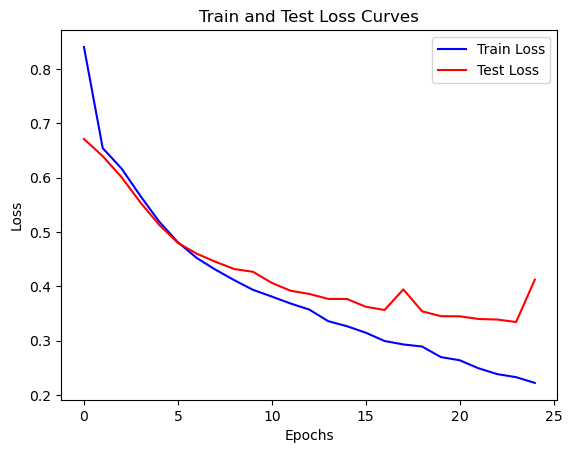

In [41]:
plt.plot(trainloss, label='Train Loss', color='blue')
plt.plot(testloss, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss Curves')
plt.legend()
plt.show()

## C1.5 Comparison

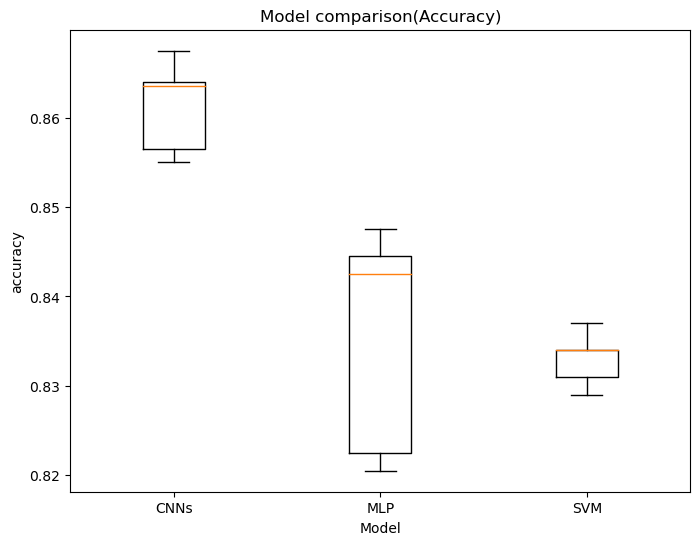

In [25]:
accuracy_cnn = np.array([result_test_cnn[i][0] for i in range(5)])
accuracy_mlp = np.array([result_test_mlp[i][0] for i in range(5)])
accuracy_svm = np.array([result_test_svm[i][0] for i in range(5)])


plt.figure(figsize=(8, 6))
plt.boxplot([accuracy_cnn, accuracy_mlp, accuracy_svm], labels=['CNNs', 'MLP', 'SVM'])
plt.title('Model comparison(Accuracy)')
plt.xlabel('Model')
plt.ylabel('accuracy')

plt.show()

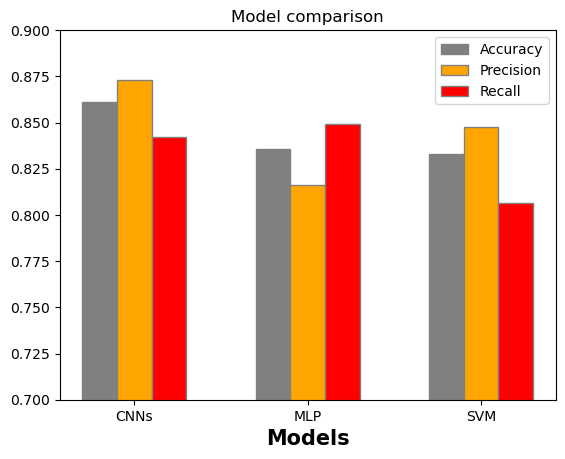

In [34]:
pre_cnn = np.array([result_test_cnn[i][1] for i in range(5)])
pre_mlp = np.array([result_test_mlp[i][1] for i in range(5)])
pre_svm = np.array([result_test_svm[i][1] for i in range(5)])

rec_cnn = np.array([result_test_cnn[i][2] for i in range(5)])
rec_mlp = np.array([result_test_mlp[i][2] for i in range(5)])
rec_svm = np.array([result_test_svm[i][2] for i in range(5)])

models = ['CNNs', 'MLP', 'SVM']
accuracy = [np.mean(accuracy_cnn),np.mean(accuracy_mlp),np.mean(accuracy_svm)]
precision = [np.mean(pre_cnn),np.mean(pre_mlp),np.mean(pre_svm)]
recall = [np.mean(rec_cnn),np.mean(rec_mlp),np.mean(rec_svm)]

barWidth = 0.2
r1 = np.arange(len(accuracy))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
                  
                    
plt.bar(r1, accuracy, color='grey', width=barWidth, edgecolor='grey', label='Accuracy')
plt.bar(r2, precision, color='orange', width=barWidth, edgecolor='grey', label='Precision')
plt.bar(r3, recall, color='red', width=barWidth, edgecolor='grey', label='Recall')

plt.xlabel('Models', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth for r in range(len(accuracy))], models)

plt.ylim([0.7,0.9])

plt.legend()
plt.title("Model comparison")
plt.show()

# C2 Model tunning

## C2.1 Tunning CNN

In [277]:
def gridSearchCVCNN(X,y,transform,para,cv=3):
    lr_p = para['lr']
    batchsize_p = para['batch_size']
    
    para_list = []
    for i in lr_p:
        lr = i
        for j in batchsize_p:
            bacthsize = j
            para_list.append([lr,bacthsize])
    accuracy_score_list = []        
    
    for paras in tqdm(para_list):
        _,result_test_cnn = crossValidationCNN(X,y,transform,cv=cv,epoch=25,batchsize=paras[1],lr=paras[0])
        ac = np.array([result_test_cnn[i][0] for i in range(cv)])
        accuracy_score_list.append(np.mean(ac))
        
    ac_list = np.array(accuracy_score_list)
    max_index = np.argmax(ac_list)
    best_para = para_list[max_index]
    
    return best_para
        
    
    

In [282]:
param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'batch_size': [100, 250, 500],
}
best_para = gridSearchCVCNN(cv_X,cv_y,transform,param_grid,cv=3)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Early stopping after 4 epochs.
On Train Set
On Test Set



 33%|███████████████████████████▋                                                       | 1/3 [02:18<04:36, 138.35s/it]

Early stopping after 4 epochs.
On Train Set
On Test Set



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:15<02:05, 125.93s/it]

Early stopping after 4 epochs.
On Train Set
On Test Set



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Early stopping after 6 epochs.
On Train Set
On Test Set



 33%|███████████████████████████▋                                                       | 1/3 [02:38<05:17, 158.57s/it]

Early stopping after 9 epochs.
On Train Set
On Test Set



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [06:23<03:17, 197.68s/it]

Early stopping after 5 epochs.
On Train Set
On Test Set



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Early stopping after 9 epochs.
On Train Set
On Test Set



 33%|███████████████████████████▋                                                       | 1/3 [03:36<07:13, 216.75s/it]

Early stopping after 7 epochs.
On Train Set
On Test Set



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [06:34<03:13, 193.52s/it]

Early stopping after 9 epochs.
On Train Set
On Test Set



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Early stopping after 6 epochs.
On Train Set
On Test Set



 33%|███████████████████████████▋                                                       | 1/3 [02:59<05:58, 179.41s/it]

Early stopping after 14 epochs.
On Train Set
On Test Set



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [08:54<04:42, 282.64s/it]

Early stopping after 12 epochs.
On Train Set
On Test Set



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Early stopping after 12 epochs.
On Train Set
On Test Set



 33%|███████████████████████████▋                                                       | 1/3 [04:53<09:47, 293.71s/it]

Early stopping after 6 epochs.
On Train Set
On Test Set



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [07:36<03:36, 216.41s/it]

Early stopping after 13 epochs.
On Train Set
On Test Set



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Early stopping after 4 epochs.
On Train Set
On Test Set



 33%|███████████████████████████▋                                                       | 1/3 [01:58<03:56, 118.18s/it]

Early stopping after 13 epochs.
On Train Set
On Test Set



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [06:59<03:45, 225.76s/it]

Early stopping after 17 epochs.
On Train Set
On Test Set



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Early stopping after 2 epochs.
On Train Set
On Test Set



 33%|████████████████████████████                                                        | 1/3 [01:21<02:42, 81.16s/it]

Early stopping after 1 epochs.
On Train Set
On Test Set



 67%|████████████████████████████████████████████████████████                            | 2/3 [02:22<01:09, 69.37s/it]

Early stopping after 1 epochs.
On Train Set
On Test Set



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Early stopping after 1 epochs.
On Train Set
On Test Set



 33%|████████████████████████████                                                        | 1/3 [00:56<01:52, 56.33s/it]

Early stopping after 3 epochs.
On Train Set
On Test Set



 67%|████████████████████████████████████████████████████████                            | 2/3 [02:37<01:22, 82.48s/it]

Early stopping after 1 epochs.
On Train Set
On Test Set



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Early stopping after 3 epochs.
On Train Set
On Test Set



 33%|████████████████████████████                                                        | 1/3 [01:36<03:13, 96.89s/it]

Early stopping after 2 epochs.
On Train Set
On Test Set



 67%|████████████████████████████████████████████████████████                            | 2/3 [02:52<01:24, 84.34s/it]

Early stopping after 2 epochs.
On Train Set
On Test Set



100%|█████████████████████████████████████████████████████████████████████████████████| 9/9 [1:17:03<00:00, 513.76s/it]


In [285]:
best_para_cnn = best_para
print("Best Hyperparameters for CNNs:", best_para)

Best Hyperparameters for CNNs: [0.001, 250]


## C2.2 Tunning SVM

In [288]:
from sklearn.model_selection import GridSearchCV

svm_model = SVC()

param_svm = {
    'C': [0.1, 1, 10], 
    'kernel': ['linear', 'rbf'],  
    'gamma': ['scale', 'auto', 0.1, 1],  
}

grid_search = GridSearchCV(estimator=svm_model, param_grid=param_svm, scoring='accuracy', cv=3)

grid_search.fit(svm_cv_X, svm_cv_y)

best_params_svm = grid_search.best_params_
print("Best Hyperparameters:", best_params_svm)

Best Hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


# C3

## C3.1 Use cross-validation to pick the best model

### C3.11 CNNs

In [295]:
result_train_cnn_aft,result_test_cnn_aft = crossValidationCNN(cv_X,cv_y,transform,cv=5,epoch=25,batchsize=best_para_cnn[1],lr=best_para_cnn[0])

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Early stopping after 4 epochs.
On Train Set
On Test Set


 20%|████████████████▌                                                                  | 1/5 [02:08<08:35, 128.88s/it]

Early stopping after 11 epochs.
On Train Set
On Test Set


 40%|█████████████████████████████████▏                                                 | 2/5 [06:53<11:02, 220.68s/it]

Early stopping after 7 epochs.
On Train Set
On Test Set


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [10:09<06:58, 209.28s/it]

Early stopping after 6 epochs.
On Train Set
On Test Set


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [13:05<03:16, 196.00s/it]

Early stopping after 8 epochs.
On Train Set
On Test Set


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [16:45<00:00, 201.13s/it]


In [296]:
result_test_cnn_aft

[[0.861, 0.8187793427230047, 0.9111807732497388],
 [0.871, 0.8314814814814815, 0.9219712525667351],
 [0.8655, 0.8893956670467503, 0.819327731092437],
 [0.8525, 0.8031278748850046, 0.9150943396226415],
 [0.8745, 0.9158016147635525, 0.8168724279835391]]

## C3.12 SVM

In [293]:
svm_model = SVC(C = 10, gamma= 'scale', kernel= 'rbf')
result_test_svm_aft = cross_val_score(svm_model, svm_cv_X, svm_cv_y, cv=5, scoring='accuracy')  

In [294]:
result_test_svm_aft

array([0.841, 0.832, 0.838, 0.84 , 0.846])

## C3.2 Comparison

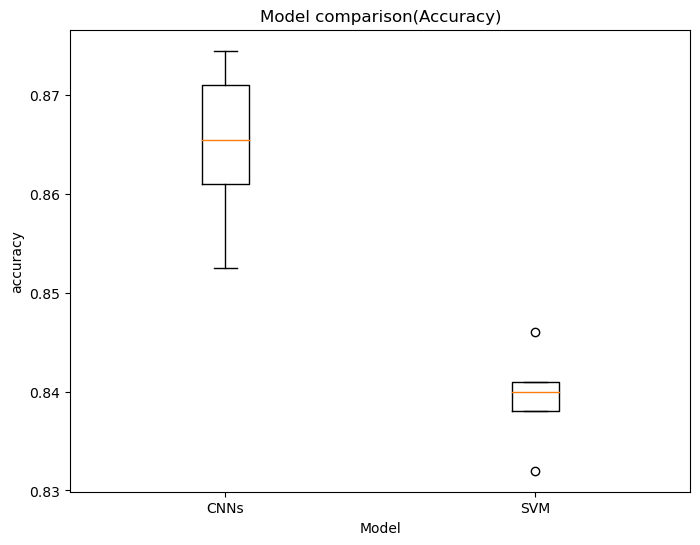

In [297]:
accuracy_cnn = [result_test_cnn_aft[i][0] for i in range(5)]
accuracy_svm = result_test_svm_aft


plt.figure(figsize=(8, 6))
plt.boxplot([accuracy_cnn, accuracy_svm], labels=['CNNs', 'SVM'])
plt.title('Model comparison(Accuracy)')
plt.xlabel('Model')
plt.ylabel('accuracy')

plt.show()

## C3.31 Train the best model(CNNs) on Train set and evaluate it on Test set

In [307]:
aft_cnn = trainCNN(cv_X,cv_y,test_X,test_y,epoch=25,batchsize=best_para_cnn[1],lr=best_para_cnn[0])
train_score,test_score,true_labels_test,predicted_labels_test,true_labels_train,predicted_labels_train = evalCNN2(aft_cnn, cv_X,cv_y,test_X,test_y,best_para_cnn[1],transform=transform)

Early stopping after 8 epochs.
On Train Set
On Test Set


In [310]:
torch.save(aft_cnn.state_dict(), 'aft_cnn.pth')

In [19]:
aft_cnn = CNN()
aft_cnn.load_state_dict(torch.load('aft_cnn.pth'))


<All keys matched successfully>

In [24]:
train_score,test_score,true_labels_test,predicted_labels_test,true_labels_train,predicted_labels_train = evalCNN2(aft_cnn, cv_X,cv_y,test_X,test_y,200,transform=transform)

On Train Set
On Test Set


## C3.32 Classification report of best model

In [110]:
report = classification_report(true_labels_test,predicted_labels_test)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3459
           1       0.88      0.88      0.88      3135

    accuracy                           0.88      6594
   macro avg       0.88      0.88      0.88      6594
weighted avg       0.88      0.88      0.88      6594



# C4

## C4.1 Visualization -- Confusion Matrix

In [26]:
def visualMatrix(labels,predicts,title=''):
    plt.figure(figsize=(8, 6))  
    sns.heatmap(confusion_matrix(labels, predicts),annot=True, fmt='d')

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


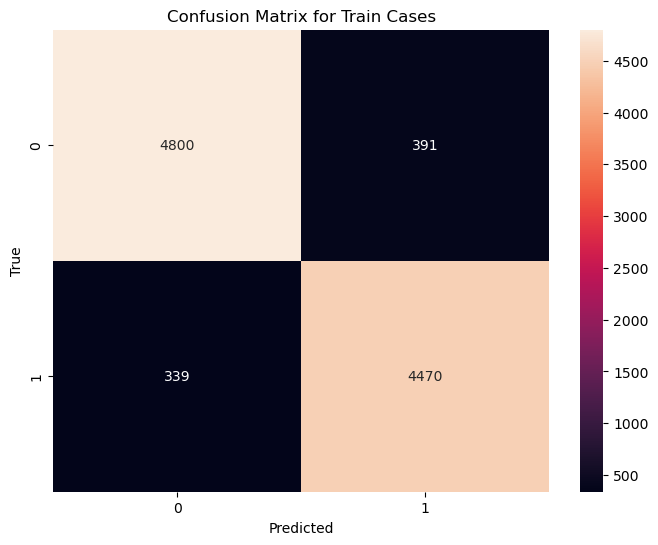

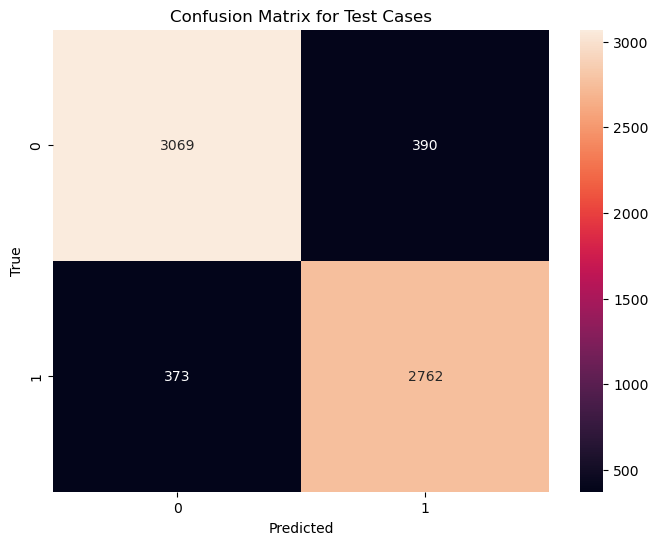

In [27]:
train_matrix = visualMatrix(true_labels_train,predicted_labels_train,title='Confusion Matrix for Train Cases')
test_matrix = visualMatrix(true_labels_test,predicted_labels_test,title='Confusion Matrix for Test Cases')

## C4.2 Visualization -- Feature extraction diagram of CNNs

In [121]:
def visualCNN(model,image_path,transform):
    device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
    input_image = Image.open(image_path)
    input_tensor = transform(input_image)
    input_batch = input_tensor.unsqueeze(0)
    
    plt.imshow(input_image)
    plt.title('The input original image')
    plt.axis('off')
    plt.show()
    
    plt.imshow(input_tensor.permute(1,2,0), cmap='gray')
    plt.title('Preprocessed image')
    plt.axis('off')
    plt.show()
    
    
    model = model.to(device)
    input_batch = input_batch.to(device)
    
    model.eval()

    target_layer = model.conv2  
    activation = {}

    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    target_layer.register_forward_hook(get_activation('conv2_output'))

    with torch.no_grad():
        model(input_batch)

    feature_map = activation['conv2_output'][0].cpu()
    plt.figure(figsize=(8, 8))
    
    for i in range(feature_map.size(0)):
        plt.subplot(8, 8, i + 1)
        plt.imshow(feature_map[i], cmap='gray') 
        plt.axis('off')
    plt.suptitle('Preprocessed image')
    plt.show()

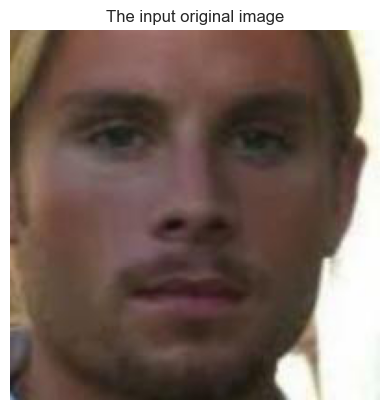

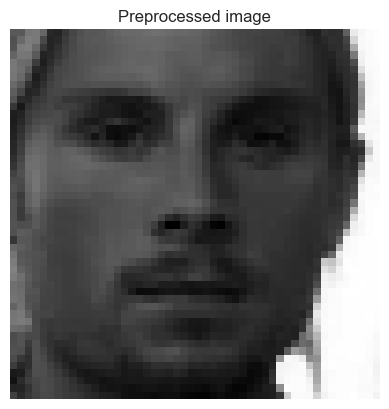

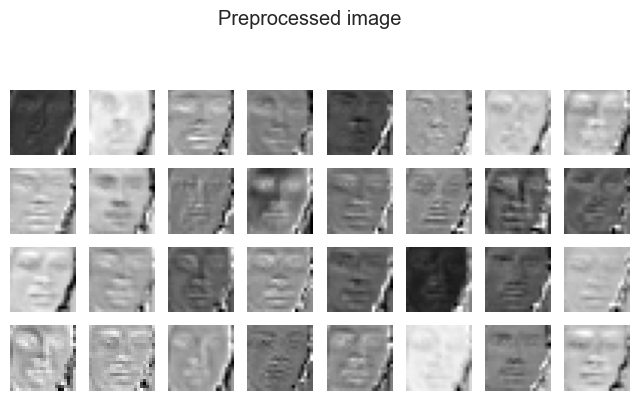

In [122]:
visualCNN(aft_cnn,X[3333],transform)

## C4.3 Visualization -- Performance of training set and test set at different age groups

In [31]:
import os

In [108]:
def excractAge(path_list):
    age_list = []
    for i in path_list:
        base_name = os.path.basename(i)
        parts = base_name.split('_')
        number = parts[0]
        number = int(number)
        age_list.append(number)
        # print(number)
    return age_list

def agecount(agelist):
    age_ranges = [(0, 10), (11, 20), (21, 30), (31, 40), (41, 50), (51, 60), (61, 70), (71, 80), (81, 90), (91, 100), (101, 200)]
    age_group = []
    for start, end in age_ranges:
        age_group.append(len([age for age in agelist if start <= age <= end]))

    return age_group

def drawdiagram(data1,data2,title='Model effects at different age groups'):

    age_ranges = [(0, 10), (11, 20), (21, 30), (31, 40), (41, 50), (51, 60), (61, 70), (71, 80), (81, 90), (91, 100), (101, 200)]
    age_label = [f'{i[0]}-{i[1]}' for i in age_ranges]
    ratio = [data2[i]/data1[i] for i in range(len(age_ranges))]

    fig, ax1 = plt.subplots(figsize=(8, 4))

    # draw bars
    ax1.bar(age_label, data1,color='blue',label='total people')
    ax1.bar(age_label, data2,color='green',label='erro')
    ax1.set_xlabel('Age groups')
    ax1.set_ylabel('Number of images')
    ax1.tick_params(axis='y')

    # draw plot
    ax2 = ax1.twinx()
    ax2.plot(age_label, ratio, marker='o', color='red', linestyle='-', linewidth=2, label='Error Ratio')
    ax2.set_ylabel('Error Ratio')
    ax2.set_ylim(0,1)
    ax2.tick_params(axis='y')

    # labels
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.title(title)
    plt.show()


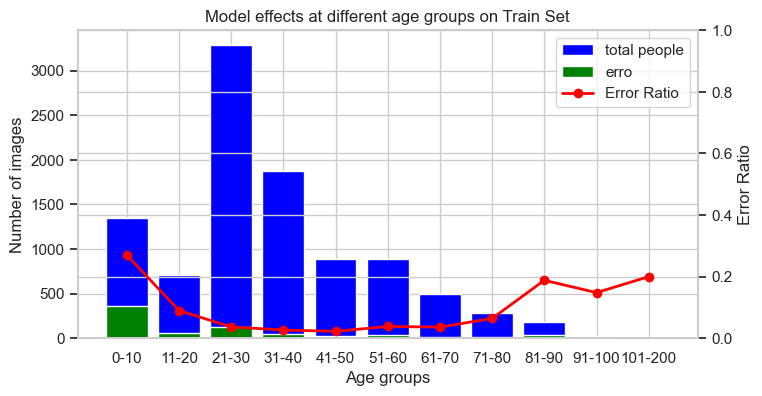

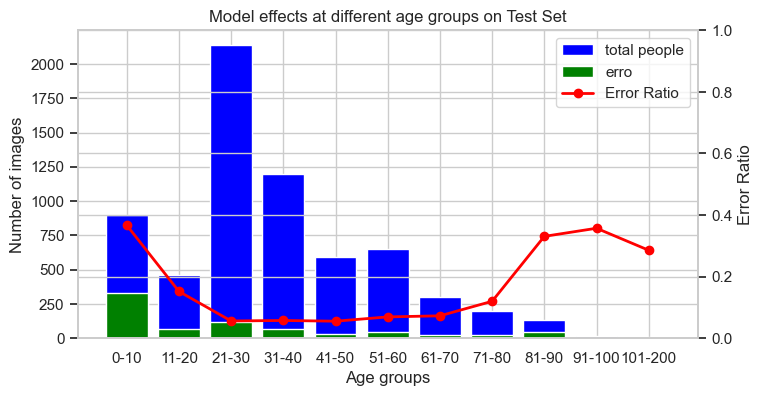

In [109]:
age_train = excractAge(cv_X)
erro_ind_train = [i for i, (a, b) in enumerate(zip(true_labels_train,predicted_labels_train)) if a != b]
age_train_erro = [age_train[i] for i in erro_ind_train]
drawdiagram(agecount(age_train),agecount(age_train_erro),title='Model effects at different age groups on Train Set')

age_test = excractAge(test_X)
erro_ind_test = [i for i, (a, b) in enumerate(zip(true_labels_test,predicted_labels_test)) if a != b]
age_test_erro = [age_test[i] for i in erro_ind_test]
drawdiagram(agecount(age_test),agecount(age_test_erro),title='Model effects at different age groups on Test Set')

## C4.4 Visualization -- Error identification analysis

In [129]:
erro_sample_X = [test_X[i] for i in erro_ind_test]
erro_sample_y = [test_y[i] for i in erro_ind_test]

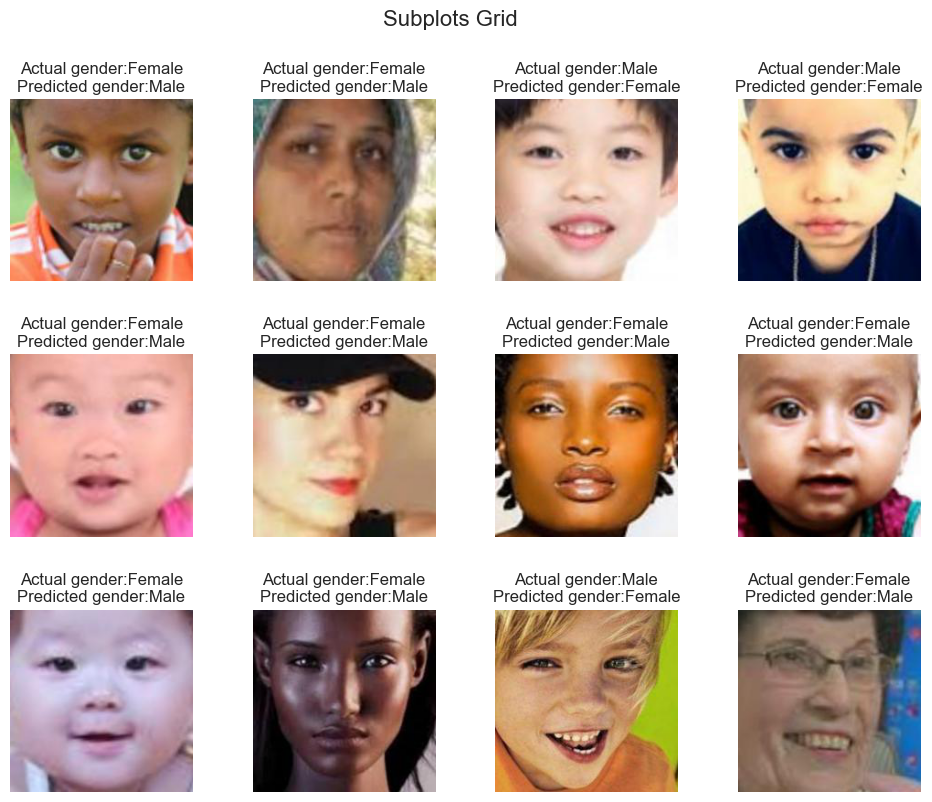

In [137]:
num_images = 12
image_shape = (50, 50)  

fig, axes = plt.subplots(3, 4, figsize=(12, 9))

for i in range(num_images):
    row = i // 4  
    col = i % 4   
    
    image_data = Image.open(erro_sample_X[i])
    true_gender = gender_mapping[erro_sample_y[i]]
    predicted_gender = gender_mapping[abs(1-erro_sample_y[i])]
    
    axes[row, col].imshow(image_data)
    axes[row, col].set_title(f'Actual gender:{true_gender}\nPredicted gender:{predicted_gender}')
    axes[row, col].axis('off')


plt.subplots_adjust(wspace=0.2, hspace=0.4)

plt.suptitle('Subplots Grid', fontsize=16)

plt.show()

# C5

In [138]:
_,test_score,true_labels_test,predicted_labels_test = evalCNN(aft_cnn, X_val,y_val,X_val,y_val,transform=transform)

On Train Set
On Test Set


In [141]:
report_val = classification_report(true_labels_test,predicted_labels_test)
print(report_val)

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3740
           1       0.87      0.89      0.88      3373

    accuracy                           0.89      7113
   macro avg       0.89      0.89      0.89      7113
weighted avg       0.89      0.89      0.89      7113



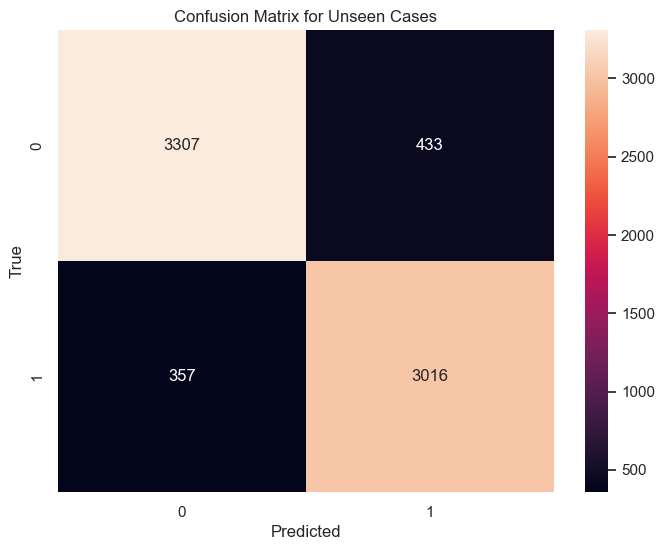

In [142]:
val_matrix = visualMatrix(true_labels_test,predicted_labels_test,title='Confusion Matrix for Unseen Cases')

# C6

In [150]:
final_cnn = CNN()
# generate dataloader
dataset = generateDataloader(X,y,transform=transform)
dataloader = DataLoader(dataset, batch_size= 250, shuffle=True)
# initialize model    
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
final_cnn = final_cnn.to(device)

criterion = nn.CrossEntropyLoss()   
optimizer = optim.Adam(final_cnn.parameters(), lr = 0.001) 
criterion = criterion.to(device)

for epoch in tqdm(range(10)):
    training_loss = []
    final_cnn.train()
    for batch_X,batch_y in dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()        
        pred_y = final_cnn(batch_X)    
        loss = criterion(pred_y, batch_y)      
        loss.backward()
        optimizer.step() 
        training_loss.append(loss.item())    

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:46<00:00, 40.68s/it]


# C7 Model saving for further application

In [151]:
torch.save(final_cnn.state_dict(), 'final_cnn.pth')